In [1]:
import numpy as np
from PIL import Image, ImageDraw
import cv2
import os
from pathlib import Path
import argparse
import sys
import matplotlib.pyplot as plt


In [2]:
image_path = "Mask/S425-2_b.tif"

img = Image.open(image_path)
np_img =  np.array(img)

np_img.shape

(1043, 5641)

In [3]:
height, width = np_img.shape[:2]
print(f"  圖片尺寸: {width} x {height}")
    
# 將遮罩轉為二值圖片
if len(np_img.shape) == 3:
    mask_gray = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
else:
    mask_gray = np_img.copy()

print(f"  原始非零像素數: {np.count_nonzero(mask_gray)}")

# 二值化處理
_, binary_mask = cv2.threshold(mask_gray, 127, 255, cv2.THRESH_BINARY)
    
print(f"  二值化後非零像素數: {np.count_nonzero(binary_mask)}")    

  圖片尺寸: 5641 x 1043
  原始非零像素數: 500684
  二值化後非零像素數: 500684


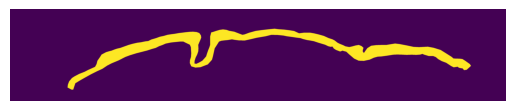

In [4]:
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

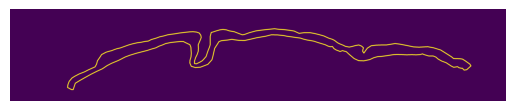

In [5]:
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

largest_contour = max(contours, key=cv2.contourArea)
black_bg = np.zeros((height, width), dtype=np.uint8)
for point in largest_contour:
	cv2.circle(black_bg, (point[0][0], point[0][1]), radius=5, color=255, thickness=-1)

plt.imshow(black_bg)
plt.axis('off')
plt.show()

In [6]:
print(binary_mask.shape)
print(binary_mask[0])

(1043, 5641)
[0 0 0 ... 0 0 0]


  底部非零像素數: 4589


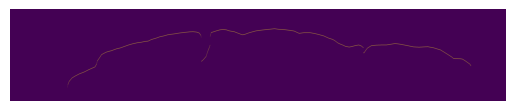

In [7]:
bottom_y = [0 for _ in range(width)]

transposed_img = binary_mask.T.copy()
for i in range(width):
    max_y = max((intensity for intensity in enumerate(transposed_img[i])), key=lambda x: x[1], default=0)
    if (max_y[1] != 0):
    	if max_y[0] > bottom_y[i]:
        	bottom_y[i] = max_y[0]

non_zero_count = sum(1 for y in bottom_y if y > 0)
print(f"  底部非零像素數: {non_zero_count}")

black_bg = np.zeros((height, width), dtype=np.uint8)
for i in range(width):
    if bottom_y[i] > 0:
        cv2.circle(black_bg, (i, bottom_y[i]), radius=1, color=255, thickness=-1)
plt.imshow(black_bg)
plt.axis('off')
plt.show()

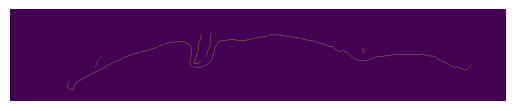

In [ ]:
def delete_upper_x(contour, mask):
	new_contour = []
	points = contour.reshape(-1, 2)  # 關鍵：先reshape

	h, w = mask.shape[:2]
	for x in range(w):
		current_x_points = points[points[:, 0] == x]
		if len(current_x_points) == 0:
			continue
		# print(f"x={x}, current_x_points={current_x_points}")
		
		max_y_idx = np.argmin(current_x_points[:, 1])
		max_y_index = current_x_points[:, 1] != current_x_points[max_y_idx, 1]

		max_y_point = current_x_points[max_y_index]

		new_contour.extend(max_y_point)
	return np.array(new_contour)


delete_upper_y_contour = delete_upper_x(largest_contour, np_img)
black_bg = np.zeros((height, width), dtype=np.uint8)
for point in delete_upper_y_contour:
	cv2.circle(black_bg, (point[0], point[1]), radius=5, color=255, thickness=-1)

plt.imshow(black_bg)
plt.axis('off')
plt.show()


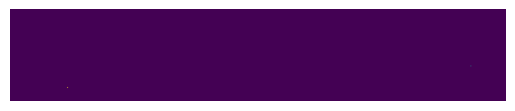

In [ ]:
def get_left_most_point(delete_upper_y_contour):
	leftmost_bottommost = None
	for point in delete_upper_y_contour:
		if leftmost_bottommost is None or point[0] < leftmost_bottommost[0] or (point[0] == leftmost_bottommost[0] and point[1] > leftmost_bottommost[1]):
			leftmost_bottommost = point

	return leftmost_bottommost

def get_right_most_point(delete_upper_y_contour):
	rightmost_bottommost = None
	for point in delete_upper_y_contour:
		if rightmost_bottommost is None or point[0] > rightmost_bottommost[0] or (point[0] == rightmost_bottommost[0] and point[1] > rightmost_bottommost[1]):
			rightmost_bottommost = point
	return rightmost_bottommost

black_bg = np.zeros((height, width), dtype=np.uint8)

cv2.circle(black_bg, get_left_most_point(delete_upper_y_contour), radius=5, color=255, thickness=-1)

cv2.circle(black_bg, get_right_most_point(delete_upper_y_contour), radius=5, color=128, thickness=-1)
plt.imshow(black_bg)
plt.axis('off')
plt.show()

i=64, current_point=[718 912]
[718 913]
segment length: 66


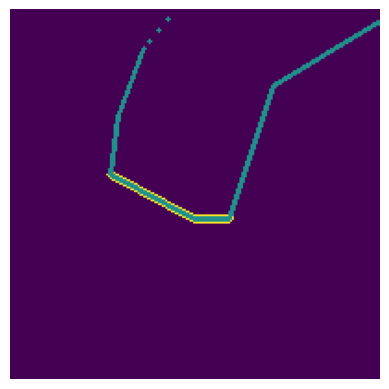

In [39]:

def get_8_connected_components(delete_upper_y_contour):
    # 獲取最左下的像素
	leftmost_bottommost = None
	rightmost_bottommost = None
	for point in delete_upper_y_contour:
		if leftmost_bottommost is None or point[0] < leftmost_bottommost[0] or (point[0] == leftmost_bottommost[0] and point[1] > leftmost_bottommost[1]):
			leftmost_bottommost = point
		if rightmost_bottommost is None or point[0] > rightmost_bottommost[0] or (point[0] == rightmost_bottommost[0] and point[1] > rightmost_bottommost[1]):
			rightmost_bottommost = point
	

	# 進行聯通元件標記
	segment = np.array([leftmost_bottommost])
	# segment = np.array([[718, 912]])
	i = 0
	while True:
		# 獲取八聯通中的點
		current_point = segment[-1]
		# 從右下開始順時鐘方向找
		directions = [(1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0)]

		finded = False

		if current_point[0] == 718 and current_point[1] == 912:
			print(f"i={i}, current_point={current_point}")

		for dx, dy in directions:
			next_point_coord = (current_point[0] + dx, current_point[1] + dy)

			next_point_exit = np.any(np.all(delete_upper_y_contour == next_point_coord, axis=1))
			if not next_point_exit:
				continue

			exist_in_segment =  np.any(np.all(segment == next_point_coord, axis=1))
			if not exist_in_segment:
				segment = np.append(segment, [next_point_coord], axis=0)
				finded = True
				break
		i += 1

		if not finded:
			print(segment[-1])
			print(f"segment length: {len(segment)}")
			break

	return np.array(segment)

bottom_contour = get_8_connected_components(delete_upper_y_contour)

black_bg = np.zeros((height, width), dtype=np.uint8)
for point in bottom_contour:
	cv2.circle(black_bg, (point[0], point[1]), radius=2, color=255, thickness=-1)

for point in delete_upper_y_contour:
	cv2.circle(black_bg, (point[0], point[1]), radius=1, color=128, thickness=-1)

plt.imshow(black_bg[800:1000, 600: 800])
plt.axis('off')
plt.show()



In [11]:

test_array = np.array([[1,2],[3,4]])

test_point = [3,2]

print()

print(np.all(np.isin(test_point, test_array)),np.isin(test_point, test_array))


True [ True  True]


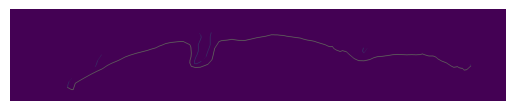

In [41]:

def get_longest_8connected_path(delete_upper_y_contour, debug=False):
    """
    找到最長的8聯通路徑（處理多個分離區域的情況）
    """
    if len(delete_upper_y_contour) == 0:
        return np.array([])
    
    point_set = set(tuple(point) for point in delete_upper_y_contour)
    visited_global = set()
    all_paths = []
    
    directions = [(1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0)]
    
    # 找到所有連通分量
    for point in delete_upper_y_contour:
        point_tuple = tuple(point)
        
        if point_tuple in visited_global:
            continue
        
        # 從這個點開始追蹤一條路徑
        path = []
        visited_local = set()
        current = point_tuple
        
        # 使用栈進行深度優先搜索
        stack = [current]
        
        while stack:
            current = stack.pop()
            
            if current in visited_local:
                continue
                
            visited_local.add(current)
            visited_global.add(current)
            path.append(current)
            
            # 找鄰居
            for dx, dy in directions:
                neighbor = (current[0] + dx, current[1] + dy)
                if (neighbor in point_set and 
                    neighbor not in visited_local and 
                    neighbor not in visited_global):
                    stack.append(neighbor)
        
        if len(path) > 1:  # 只保留有意義的路徑
            all_paths.append(path)
    
    if not all_paths:
        return np.array([])
    
    # 返回最長的路徑
    longest_path = max(all_paths, key=len)
    
    if debug:
        print(f"找到 {len(all_paths)} 個連通分量")
        print(f"最長路徑長度: {len(longest_path)}")
    
    return np.array(longest_path)

bottom_contour = get_longest_8connected_path(delete_upper_y_contour)

black_bg = np.zeros((height, width), dtype=np.uint8)
for point in bottom_contour:
	cv2.circle(black_bg, (point[0], point[1]), radius=2, color=255, thickness=-1)

for point in delete_upper_y_contour:
	cv2.circle(black_bg, (point[0], point[1]), radius=1, color=128, thickness=-1)

# plt.imshow(black_bg[800:1000, 600: 800])
plt.imshow(black_bg)
plt.axis('off')
plt.show()